<a href="https://colab.research.google.com/github/giovanni-lucarelli/distribution-shift/blob/main/datasetV03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, bernoulli
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations_with_replacement

# Functions

## Features

In [115]:
def attributes_quantile(df, probability):
  quantiles= df.quantile(probability)
  quantiles = quantiles[:-1] # Remove the last element

  return quantiles

In [116]:
def random_cov(num_features, low=-1, high=1):
  # Define the covariance matrix
  covariance = np.random.uniform(low, high, size=(num_features, num_features))
  covariance = np.dot(covariance, covariance.transpose()) # positive semidef

  return covariance

In [117]:
def build_multivariate_sample(num_samples, mean, covariance):
  # Create the multivariate normal distribution
  mvn = multivariate_normal(mean=mean, cov=covariance)

  # Generate random samples
  samples = mvn.rvs(size=num_samples)

  return samples

In [132]:
def build_mixture_sample(num_samples, mean1, cov1, mean2, cov2, mix_prob):
    """
    Build a random sample from a statistical mixture of two multivariate distributions.

    Parameters:
    - num_samples: Number of samples to generate.
    - mean1, cov1: Mean and covariance of the first multivariate normal distribution.
    - mean2, cov2: Mean and covariance of the second multivariate normal distribution.
    - mix_prob: Mixing probability for the first distribution (0 <= mix_prob <= 1).

    Returns:
    - samples: An array of generated samples.
    """
    # Create the two multivariate normal distributions
    mvn1 = multivariate_normal(mean=mean1, cov=cov1)
    mvn2 = multivariate_normal(mean=mean2, cov=cov2)

    # Generate Bernoulli trials to decide which distribution to sample from
    mixture_selection = bernoulli.rvs(mix_prob, size=num_samples)

    # Allocate space for the samples
    samples = np.zeros((num_samples, len(mean1)))

    # Generate samples based on the Bernoulli outcomes
    for i in range(num_samples):
        if mixture_selection[i] == 0:
            samples[i] = mvn1.rvs()
        else:
            samples[i] = mvn2.rvs()

    return samples

## Target

In [119]:
def polynomial(samples, degree, coefficients=None):
    num_samples = samples.shape[0]
    num_features = samples.shape[1]
    terms = []
    generated_coefficients = []  # To store generated coefficients if not provided

    # Generate all combinations of feature indices for terms up to the specified degree
    for d in range(degree + 1):
        for combo in combinations_with_replacement(range(num_features), d):
            terms.append(combo)

    if coefficients is None:
        # Generate random coefficients if not provided
        coefficients = [np.random.uniform(-1, 1) for _ in terms]
        generated_coefficients = coefficients

    polynomial_values = np.zeros(num_samples)
    for combo, coefficient in zip(terms, coefficients):
        # Compute the term for each sample
        term_values = np.prod(samples[:, combo], axis=1) if combo else np.ones(num_samples)
        polynomial_values += coefficient * term_values

    # Return the polynomial values and either the passed or generated coefficients
    return polynomial_values, (coefficients if generated_coefficients == [] else generated_coefficients)

In [120]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [121]:
def build_poly_target(sample, degree, coefficients=None):
  polynomial_values, coef = polynomial(sample, degree, coefficients)

  prob1 = sigmoid(polynomial_values)

  y = np.random.binomial(1, prob1)

  return y, coef

# Dataset Construction

In [ ]:
set_seed = 42
np.random.seed(set_seed)

### Parameters of the problem

In [151]:
num_samples = 1000
num_features = 3

# degree of the polinomio for the attribute relationship
degree = 2

,count
Y,
0,519
1,481


## Training Set

In [ ]:
# random multivariate
mean_train = np.random.rand(num_features)
covariance_train = random_cov(num_features)

# build the x_i sample
sample_train = build_multivariate_sample(num_samples, mean_train, covariance_train)
df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])

# build target variable y
y_train, coef_train = build_poly_target(sample_train, degree)
df_train['Y'] = y_train

# check for balance
df_train['Y'].value_counts()

## Shifted Set

In [223]:
# shifted random multivariate
mean_shift = attributes_quantile(df_train, 0.90)
covariance_shift = random_cov(num_features, low = -0.5, high=0.5)

# build the shifted x_i sample
sample_shift = build_multivariate_sample(num_samples, mean_shift, covariance_shift)
df_shift = pd.DataFrame(sample_shift, columns=[f'X{i+1}' for i in range(num_features)])

# build target variable y
y_shift, coef_shift = build_poly_target(sample_shift, degree, coefficients=coef_train)
df_shift['Y'] = y_shift

# check for balance in the shifted
df_shift['Y'].value_counts()

,count
Y,
0,772
1,228


## Generate mixtures

To be as general as possible, we consider statistical mixtures and study the presumed progressive degradation in performance for increasingly pure mixtures towards the test distribution.

In [257]:
# Initialize an empty dictionary to store the DataFrames
df_dict = {}

# Iterate over mix_prob values
for mix_prob in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # Generate mixture sample
    sample_mix = build_mixture_sample(num_samples, mean_train, covariance_train, mean_shift, covariance_shift, mix_prob=mix_prob)

    # Create a DataFrame for the features
    df_mix = pd.DataFrame(sample_mix, columns=[f'X{i+1}' for i in range(num_features)])

    # Build the target variable y
    y_mix, coef_mix = build_poly_target(sample_mix, degree, coefficients=coef_train)
    df_mix['Y'] = y_mix

    # Store the DataFrame in the dictionary
    df_dict[mix_prob] = df_mix


In [ ]:
# Display the value counts for 'Y' for each mix_prob
for mix_prob, df in df_dict.items():
    print(f"mix_prob={mix_prob}:")
    print(df['Y'].value_counts())

## Some Plots

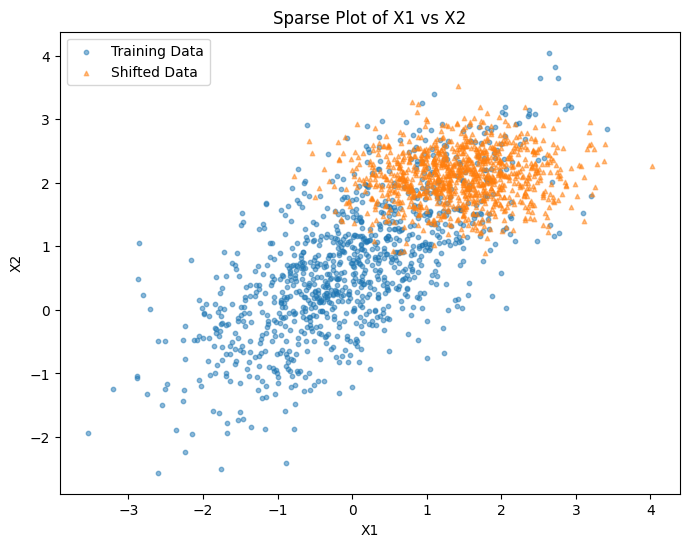

In [224]:
plt.figure(figsize=(8, 6))
plt.scatter(df_train['X1'], df_train['X2'], label='Training Data', alpha=0.5, s=10) # sparse plot for df_train
plt.scatter(df_shift['X1'], df_shift['X2'], label='Shifted Data', alpha=0.5, s=10, marker='^') # sparse plot for df_shift
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Sparse Plot of X1 vs X2')
plt.legend()
plt.show()

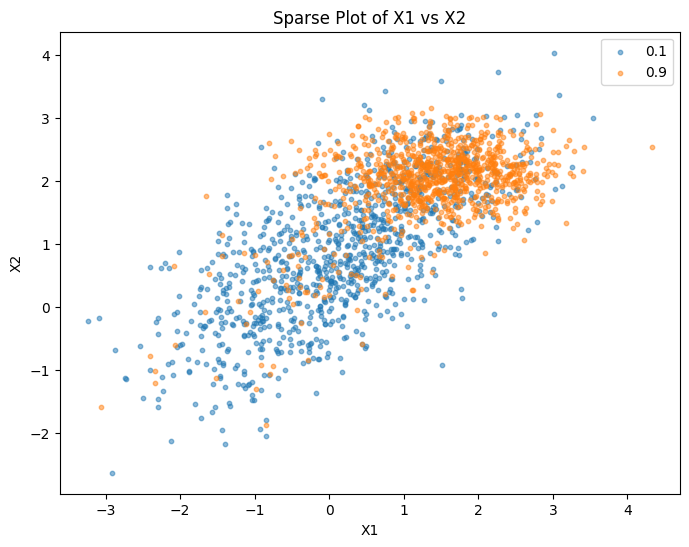

In [258]:
plt.figure(figsize=(8, 6))
plt.scatter(df_dict[0.1]['X1'], df_dict[0.1]['X2'], label='0.1', alpha=0.5, s=10) # sparse plot for df_train
plt.scatter(df_dict[0.9]['X1'], df_dict[0.9]['X2'], label='0.9', alpha=0.5, s=10) # sparse plot for df_train
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Sparse Plot of X1 vs X2')
plt.legend()
plt.show()

In [253]:
def hist_compare(df1, df2, attribute, kernel=True):
  sns.histplot(df1[attribute], kde = kernel) # kernel density estimation
  sns.histplot(df2[attribute], kde = kernel) # kernel density estimation
  plt.show()

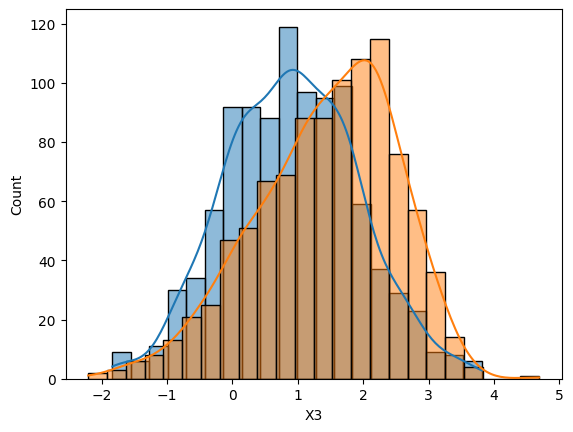

In [256]:
hist_compare(df_train, df_dict[0.4], 'X3')

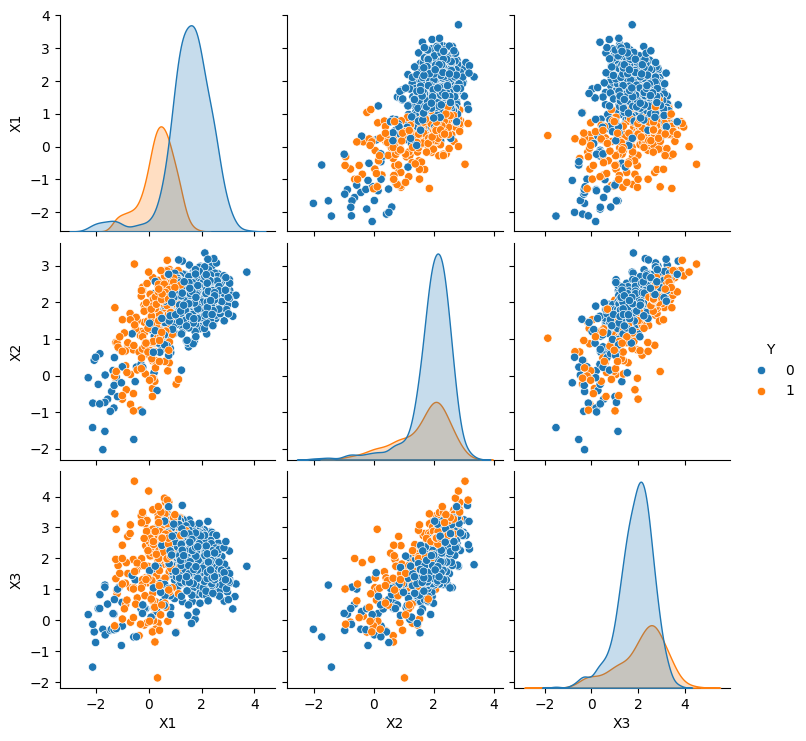

In [263]:
sns.pairplot(df_dict[0.8], vars=['X1', 'X2', 'X3'], hue='Y')
plt.show()

## Saving Data to Files

**Obs:** df_train is equivalent to df_mix[0.0] as well as df_shift is eq. to df_mix[1.0]

In [269]:
import os

# Create a folder
folder_name = 'data'
os.makedirs(folder_name, exist_ok=True)

# Save DataFrames to CSV files within the folder
df_train.to_csv(os.path.join(folder_name, 'train.csv'), index=False)
df_shift.to_csv(os.path.join(folder_name, 'shift.csv'), index=False)

for mix_prob, df in df_dict.items():
    df.to_csv(os.path.join(folder_name, f'mix_{mix_prob}.csv'), index=False)

Saving the all the parameters used to generate the data into `Parameters.txt`

In [270]:
file_name = 'Parameters.txt'
file_path = os.path.join(folder_name, file_name)

with open(file_path, 'w') as f:
  f.write('Polinomial coefficients\n')
  f.write(f'{coef_train}\n')
  f.write('Mean train\n')
  f.write(f'{mean_train}\n')
  f.write('Covariance train\n')
  f.write(f'{covariance_train}\n')
  f.write('Mean shift\n')
  f.write(f'{mean_shift}\n')
  f.write('Covariance shift\n')
  f.write(f'{covariance_shift}\n')

## (Optional) Download all the files

If workig from Colab

In [272]:
# from google.colab import files
# import glob

# # Get all files within the 'data' directory
# all_files = glob.glob('data/*')

# # Download each file individually
# for file in all_files:
#   files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>